Notebook root: /home/tiberiu/Documents/TAID/SCAV/Similar-Images-Recognition
Embeddings path: /home/tiberiu/Documents/TAID/SCAV/Similar-Images-Recognition/models/cbir_embeddings.pt
Paths CSV: /home/tiberiu/Documents/TAID/SCAV/Similar-Images-Recognition/models/cbir_image_paths.csv
Running short training: samples=400, epochs=5, device=cuda
Epoch 1/5 | train_loss=0.0833 val_loss=0.0245 time=13.53s
Epoch 2/5 | train_loss=0.0553 val_loss=0.0158 time=13.52s
Epoch 3/5 | train_loss=0.0528 val_loss=0.0175 time=13.41s
Epoch 4/5 | train_loss=0.0462 val_loss=0.0128 time=13.31s
Epoch 5/5 | train_loss=0.0311 val_loss=0.0226 time=13.39s


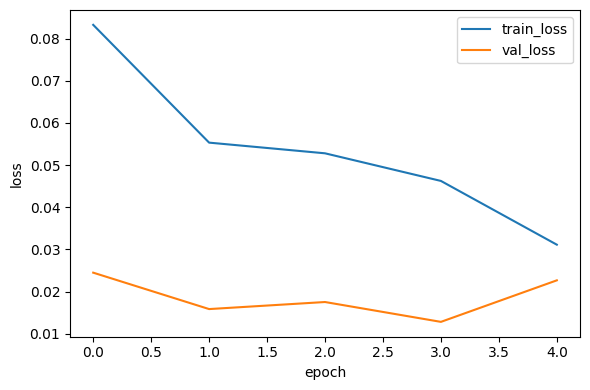


Training run complete. Summary:
train_loss: [0.08325600065290928, 0.05531499199569225, 0.05278315395116806, 0.04623030237853527, 0.03110811747610569]
val_loss: [0.024470439180731773, 0.01583241974003613, 0.017506041564047337, 0.012796560612817606, 0.022648527364556987]


In [ ]:
# Metrics, short training run, and plots (LOSS ONLY)
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from classes import SiameseDataset, SiameseNet
from classes.ContrastiveLoss import ContrastiveLoss
from main import Config, get_transforms, train_one_epoch
import numpy as np

NOTEBOOK_ROOT = os.path.dirname(os.path.abspath("tests.ipynb"))
EMB_PATH = os.path.join(NOTEBOOK_ROOT, "models", "cbir_embeddings.pt")
PATHS_CSV = os.path.join(NOTEBOOK_ROOT, "models", "cbir_image_paths.csv")

print("Notebook root:", NOTEBOOK_ROOT)
print("Embeddings path:", EMB_PATH)
print("Paths CSV:", PATHS_CSV)


# Helpers
def compute_loss(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for img1, img2, target in loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            target = target.to(device)

            z1, z2 = model(img1, img2)
            loss = criterion(z1, z2, target)
            running_loss += loss.item()

    return running_loss / len(loader)


def load_embeddings(path=EMB_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Embeddings file not found: {path}")
    emb = torch.load(path)
    if isinstance(emb, torch.Tensor):
        emb = emb.cpu().numpy()
    emb = np.asarray(emb)
    return emb


def load_paths(path=PATHS_CSV, skip_header=True):
    """Load image paths from CSV. By default skip the first row (header/metadata)."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Paths CSV not found: {path}")
    # some CSVs include a header or metadata in the first row; skip it by default
    if skip_header:
        df = pd.read_csv(path, header=None, skiprows=1)
    else:
        df = pd.read_csv(path, header=None)
    return df.iloc[:, 0].astype(str).tolist()


# Prepare small dataset from existing paths
train_tf, val_tf = get_transforms()
cfg = Config()

df_all = pd.DataFrame({"path": load_paths()})
if len(df_all) < 20:
    raise RuntimeError("Not enough images to run a short training demo (need >=20)")

n_samples = min(400, len(df_all))  # cap for quick runs
subset = df_all.sample(n=n_samples, random_state=cfg.SEED).reset_index(drop=True)
train_df, val_df = train_test_split(subset, test_size=0.2, random_state=cfg.SEED)

train_dataset = SiameseDataset(train_df, transform=train_tf)
val_dataset = SiameseDataset(val_df, transform=val_tf)

train_loader = DataLoader(
    train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0
)

# Model and training setup
model = SiameseNet(embedding_dim=cfg.EMBEDDING_DIM).to(cfg.DEVICE)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)

EPOCHS = 5

history = {
    "train_loss": [],
    "val_loss": [],
}

print(
    f"Running short training: samples={n_samples}, epochs={EPOCHS}, device={cfg.DEVICE}"
)

for epoch in range(EPOCHS):
    t0 = time.perf_counter()

    train_one_epoch(model, train_loader, optimizer, criterion, cfg.DEVICE)

    train_loss = compute_loss(model, train_loader, criterion, cfg.DEVICE)
    val_loss = compute_loss(model, val_loader, criterion, cfg.DEVICE)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    t1 = time.perf_counter()

    print(
        f"Epoch {epoch + 1}/{EPOCHS} | "
        f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
        f"time={(t1 - t0):.2f}s"
    )

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.show()

print("\nTraining run complete. Summary:")
for k in history:
    print(f"{k}: {history[k]}")
